In [186]:
#Importing all the libraries
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, create_session
from sqlalchemy import create_engine, MetaData, Table, Column, ForeignKey,inspect, func
import datetime as dt
import numpy as np

In [187]:
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [188]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [189]:
#create engine and import sqlite file
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn= engine.connect()

In [190]:
#automap_base to show tables in classes

Base = automap_base()
Base. prepare(engine, reflect = True)


In [191]:
Base.classes.keys()

['measurement', 'station']

In [192]:
#show a reference for measurement and station classes.

Station = Base.classes.station
Measurement = Base.classes.measurement

In [193]:
session = Session(engine)

# Precipitation Analysis


Design a query to retrieve the last 12 months of precipitation data.

Select only the date and prcp values.

Load the query results into a Pandas DataFrame and set the index to the date column.

Sort the DataFrame values by date.

Plot the results using the DataFrame plot method.

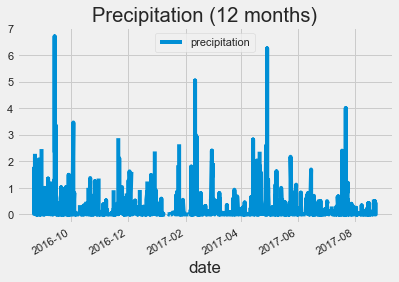

In [194]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
last_12_months = last_12_months[0]

# Calculate the date 1 year ago from today
# The days are equal 366 so that the first day of the year is included
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df .plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.show()

In [195]:
#Use Pandas to print the summary statistics for the precipitation data.
result_pd.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


# Station Analysis


Design a query to calculate the total number of stations.

Design a query to find the most active stations.


List the stations and observation counts in descending order.
Which station has the highest number of observations?
Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.



Design a query to retrieve the last 12 months of temperature observation data (tobs).


Filter by the station with the highest number of observations.
Plot the results as a histogram with bins=12.

In [196]:
# How many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()



In [197]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order. 


active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [198]:
#Which station has the highest number of observations?
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [199]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

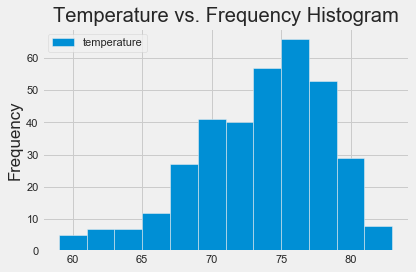

In [200]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# We need 12 bins since the observation is for twelve months
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()

plt.show()

In [201]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    # Docstring for the function `calc_temps`
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    # Query the minimum, average and maximum temperatures
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Call on the function with the dates provided
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


# Temperature Analysis (Optional)


The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

Plot the min, avg, and max temperature from your previous query as a bar chart.


Use the average temperature as the bar height.
Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [202]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-01-01','2018-01-01')
trip

[(58.0, 74.14387974230493, 87.0)]

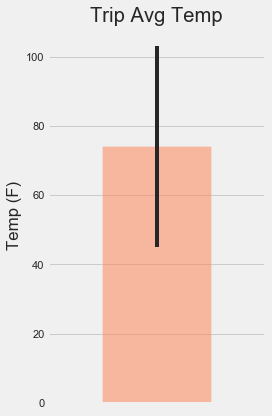

In [203]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])


# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
# plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [204]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-01-01','2018-01-01'))

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]
